In [1]:
import gzip
import csv
import json
import pandas as pd
import numpy as np
import seaborn as sns
import os, random, math, glob
from IPython.display import Image as IM
from IPython.display import clear_output
from matplotlib import pyplot as plt
import datetime
import scipy.optimize as sco
from scipy import stats
%matplotlib inline
import scipy
#import pandas_profiling as pp
from sqlalchemy import create_engine
import matplotlib
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.base import TransformerMixin
from sklearn.base import TransformerMixin, BaseEstimator
#from sklearn_pandas import CategoricalImputer
from scipy.stats import norm
#from __future__ import division
import random
import math
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
#!pip install imblearn
#from imblearn.under_sampling import RandomUnderSampler
#import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
#from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]

In [2]:
Ret36 = pd.read_excel('Rett36_bal_amor.xlsx')
Ret36 = Ret36/100

In [3]:
Cova_matrix_Ret36 = Ret36.cov()
Corr_matrix_Ret36 = Ret36.corr()
Daily_mean_Ret36 = np.mean(Ret36)

In [4]:
class Particle:
    def __init__(self, num_port):
        self.position =  Particle.initial_swarm(num_port)
        self.pbest_position = self.position
        self.pbest_value = 0.001645 
        self.velocity = np.zeros(num_port)

    def move(self):
        proxy = self.position + self.velocity
        proxy = np.where(proxy>1, 1, proxy) # upper bound
        proxy = np.where(proxy<0, 0, proxy) # lower bound
        # print(proxy)
        self.position = proxy/np.sum(proxy)

    @staticmethod
    def initial_swarm(x):
        array = np.array([random.random() for i in range(x)])
        sum1 = np.sum(array)
        return array/sum1 # normalized weights


In [5]:
class Space:
    def __init__(self, n_particles, num_port, returns, vol, alpha, w, c1, c2):
        self.n_particles = n_particles
        self.particles = []
        self.gbest_value = 0.001645
        self.alpha = alpha #sensitivity to sharpe
        self.n_stocks = num_port        
        self.gbest_position = Space.initial_swarm(num_port)
        self.returns = returns
        self.vol = vol #volatility matrix (variance)
        self.w = w
        self.c1 = c1
        self.c2 = c2

    @staticmethod
    def initial_swarm(x):
        array = np.array([random.random() for i in range(x)])
        sum1 = np.sum(array)
        return array/sum1 # normalized weights
    
    # fitness function for portfolio optimization

 # fitness function for portfolio optimization
    def fitness(self, particle):
        return_ = np.dot(particle.position,np.transpose(self.returns))
        vol = np.dot(np.dot(particle.position,self.vol),np.transpose(particle.position))
        self.sharpe = (return_ - rf)/np.sqrt(vol) 

        # w\cdot covariance\:matrix\times w^{T}
        vols = np.dot(particle.position,self.vol)*particle.position
        
        # volatility\:dispersion=\sum (stock\:risk\:contibution_{i} -average\:risk)
        self.vol_dis = np.sum(abs(np.sqrt(vols)-np.mean(np.sqrt(vols))))
      
        # \frac{Sharpe\times\alpha+1 }{volaltility\:dispersion\times(1-\alpha)+1}
        result = (self.sharpe*self.alpha+1)/(self.vol_dis*(1-self.alpha)+1)
        return result 


    def set_pbest(self):
        for particle in self.particles:
            fitness_candidate = self.fitness(particle)
            if (particle.pbest_value < fitness_candidate):
                particle.pbest_value = fitness_candidate
                particle.pbest_position = particle.position

    def set_gbest(self):
        for particle in self.particles:
            best_fitness_candidate = self.fitness(particle)
            if(self.gbest_value < best_fitness_candidate):
                self.gbest_value = best_fitness_candidate
                self.gbest_position = particle.position

    def move_particles(self):
        for particle in self.particles:
            new_velocity = (self.w*particle.velocity) + (self.c1*random.random()) * (particle.pbest_position - particle.position) + \
                            (random.random()*self.c2) * (self.gbest_position - particle.position)
            particle.velocity = new_velocity
            particle.move()

In [6]:
import pandas as pd
import os
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import matplotlib.ticker as mtick

cov_matrix = Cova_matrix_Ret36
returns = Daily_mean_Ret36
rf = 0.10


dic_pos = {}
best_values, sharpes, disp= [], [], []

for a in range(0,100,1):
    alpha = a/100
    search_space = Space(30, 7, returns, cov_matrix, alpha, w=0.5, c1=0.8, c2=0.9)
    particles_vector = [Particle(search_space.n_stocks) for _ in range(search_space.n_particles)]
    search_space.particles = particles_vector
    n_iterations =1000
        # algo
    iteration = 0
    prev_gbest_value = 0.001645
    while(iteration < n_iterations):
        search_space.set_pbest()    
        search_space.set_gbest()

        if(abs(search_space.gbest_value - prev_gbest_value) < 0.001645) and (iteration>3):
            break
        prev_gbest_value = search_space.gbest_value
        print('Iteration: {0} Position {1}, Value: {2:.3f}'.format(iteration, 
                                                                search_space.gbest_position, search_space.gbest_value))
        search_space.move_particles()
        iteration += 1
    print('finished {} ---------'.format(alpha))
        
    best_values.append(search_space.gbest_value)
    sharpes.append(search_space.sharpe)
    disp.append(search_space.vol_dis)
    #return_.append(search_space.return_)
    dic_pos[a] = search_space.gbest_position
    


a = np.array(list(dic_pos.values()))
A = a[:,0]
B = a[:,1]
C = a[:,2]
D = a[:,3]
E = a[:,4]
F = a[:,5]
G = a[:,6]
#ret = a[:,7]
#vol = a[:,8]
#sharp = a[:,9]
etf_list = [A, B, C, D, E, F, G]#, ret, vol, sharp]
etf_list_sf = [savgol_filter(i, 9, 5) for i in etf_list]
total_sf = np.array(etf_list_sf)
total = np.array(etf_list)

Iteration: 0 Position [0.21438101 0.18198658 0.15654782 0.19596325 0.18761163 0.04172522
 0.02178449], Value: 0.993
Iteration: 1 Position [0.18197887 0.16100462 0.17662146 0.17041685 0.14119633 0.09557498
 0.0732069 ], Value: 0.995
Iteration: 2 Position [0.1801319  0.19158564 0.134319   0.17690867 0.1183462  0.08301978
 0.11568881], Value: 0.996
Iteration: 3 Position [0.19885552 0.16388833 0.19537932 0.16750964 0.13712837 0.04873614
 0.08850269], Value: 0.997
finished 0.0 ---------
Iteration: 0 Position [0.07364188 0.12881955 0.10172651 0.16551859 0.2338729  0.08403953
 0.21238104], Value: 1.312
Iteration: 1 Position [0.09221366 0.07902693 0.26771585 0.10391367 0.13847858 0.07849776
 0.24015356], Value: 1.330
Iteration: 2 Position [0.08564382 0.07997728 0.24996746 0.11047015 0.15902665 0.06738262
 0.24753202], Value: 1.332
Iteration: 3 Position [0.0700931  0.09629378 0.21806869 0.14137058 0.17422772 0.06498507
 0.23496108], Value: 1.333
finished 0.01 ---------
Iteration: 0 Position [0.

Iteration: 10 Position [0.13558015 0.0854214  0.22395424 0.16841741 0.13445922 0.06098775
 0.19117982], Value: 3.704
Iteration: 11 Position [0.13354795 0.08524281 0.23065617 0.16379084 0.14080269 0.05765551
 0.18830404], Value: 3.713
Iteration: 12 Position [0.13613898 0.08615629 0.23422655 0.15709225 0.14460824 0.05489823
 0.18687946], Value: 3.718
Iteration: 13 Position [0.13402314 0.08645873 0.24032415 0.15278503 0.14968505 0.05247768
 0.1842462 ], Value: 3.722
Iteration: 14 Position [0.13044284 0.07824341 0.24516068 0.15495543 0.15173574 0.05401401
 0.18544789], Value: 3.724
Iteration: 15 Position [0.13134517 0.08025909 0.25029155 0.14691457 0.15127144 0.05470918
 0.185209  ], Value: 3.727
finished 0.08 ---------
Iteration: 0 Position [0.1213385  0.11225274 0.26830357 0.0137818  0.15838133 0.09073359
 0.23520847], Value: 3.863
Iteration: 1 Position [0.11701172 0.11050912 0.25200215 0.1269201  0.19704564 0.04734834
 0.14916292], Value: 4.008
Iteration: 2 Position [0.11399662 0.139343

 0.20295757], Value: 6.129
Iteration: 14 Position [0.09664318 0.08036027 0.25054367 0.15959525 0.15642661 0.05325845
 0.20317258], Value: 6.131
Iteration: 15 Position [0.09084719 0.08167641 0.2581612  0.15942069 0.15444703 0.05360042
 0.20184706], Value: 6.136
Iteration: 16 Position [0.0879492  0.08233447 0.26196996 0.15933341 0.15345725 0.05377141
 0.2011843 ], Value: 6.138
Iteration: 17 Position [0.08329811 0.08413853 0.26689236 0.1570035  0.15128183 0.05449377
 0.20289191], Value: 6.141
Iteration: 18 Position [0.07926759 0.085249   0.27190311 0.15618632 0.14970388 0.05484205
 0.20284805], Value: 6.143
finished 0.15 ---------
Iteration: 0 Position [0.12949415 0.14761352 0.21492524 0.08083232 0.22615177 0.00877382
 0.19220919], Value: 6.029
Iteration: 1 Position [0.11222049 0.1400085  0.20622915 0.10333604 0.18272801 0.05376707
 0.20171073], Value: 6.346
Iteration: 2 Position [0.14307061 0.1377713  0.22410613 0.10838212 0.16533733 0.04919683
 0.17213568], Value: 6.355
Iteration: 3 Pos

 0.20081119], Value: 8.194
Iteration: 15 Position [0.1101086  0.05581931 0.27399259 0.14745268 0.15902869 0.05326877
 0.20032935], Value: 8.196
finished 0.21 ---------
Iteration: 0 Position [0.08652102 0.01871572 0.2088785  0.16007512 0.32110004 0.04265319
 0.1620564 ], Value: 7.827
Iteration: 1 Position [0.08313963 0.09223631 0.15573428 0.1674014  0.23163151 0.06329597
 0.2065609 ], Value: 8.260
Iteration: 2 Position [0.08313963 0.09223631 0.15573428 0.1674014  0.23163151 0.06329597
 0.2065609 ], Value: 8.260
Iteration: 3 Position [0.13764626 0.14952043 0.19059548 0.10451848 0.18100435 0.05722993
 0.17948508], Value: 8.278
Iteration: 4 Position [0.10968205 0.11827488 0.17513249 0.13525357 0.20917659 0.05875703
 0.1937234 ], Value: 8.320
Iteration: 5 Position [0.10460267 0.09529863 0.18114948 0.13566206 0.2160283  0.06339616
 0.2038627 ], Value: 8.344
Iteration: 6 Position [0.11088923 0.0936713  0.18956893 0.1235938  0.20567092 0.06640674
 0.21019908], Value: 8.371
Iteration: 7 Positio

 0.19810201], Value: 9.534
Iteration: 15 Position [0.13196694 0.04248931 0.29331262 0.12230453 0.15616625 0.05732526
 0.1964351 ], Value: 9.536
Iteration: 16 Position [0.13035547 0.04629939 0.29425056 0.1202258  0.1550212  0.05791122
 0.19593637], Value: 9.538
finished 0.25 ---------
Iteration: 0 Position [0.09026809 0.08832185 0.21985467 0.18666602 0.21153342 0.02164741
 0.18170854], Value: 9.579
Iteration: 1 Position [0.12335189 0.08894449 0.20943842 0.13863035 0.17538757 0.07337719
 0.1908701 ], Value: 9.775
Iteration: 2 Position [0.10454484 0.05475503 0.23684722 0.15572433 0.18763305 0.04836614
 0.2121294 ], Value: 9.851
Iteration: 3 Position [0.09568883 0.03633355 0.25972134 0.1401739  0.19719986 0.0546599
 0.21622261], Value: 9.853
Iteration: 4 Position [0.08677459 0.04680434 0.27501218 0.14720513 0.16739327 0.04733929
 0.2294712 ], Value: 9.893
Iteration: 5 Position [0.083471   0.06533453 0.26625125 0.14762606 0.16802601 0.06459348
 0.20469766], Value: 9.916
Iteration: 6 Positio

 0.19797689], Value: 11.488
Iteration: 2 Position [0.10738354 0.11083629 0.17411797 0.13034137 0.18021951 0.08201922
 0.21508211], Value: 11.662
Iteration: 3 Position [0.0087655  0.12505002 0.22476223 0.17425923 0.20888939 0.06266957
 0.19560405], Value: 11.776
Iteration: 4 Position [0.0101373  0.0795817  0.24803739 0.15011445 0.17048901 0.07574164
 0.26589851], Value: 11.868
Iteration: 5 Position [0.00987992 0.09443662 0.24362261 0.16352886 0.1825329  0.07360773
 0.23239136], Value: 11.903
Iteration: 6 Position [0.         0.07227903 0.28052051 0.13797162 0.1967529  0.07003716
 0.24243878], Value: 11.931
Iteration: 7 Position [0.         0.08134727 0.29592754 0.14445705 0.17631313 0.07232269
 0.22963232], Value: 11.962
Iteration: 8 Position [0.         0.07275048 0.28536629 0.15716745 0.17894231 0.06676314
 0.23901033], Value: 11.966
Iteration: 9 Position [0.         0.07234374 0.31632329 0.14744986 0.16639082 0.06550299
 0.2319893 ], Value: 11.982
Iteration: 10 Position [0.         0

 0.19738968], Value: 13.631
Iteration: 11 Position [0.05400734 0.08150039 0.25321977 0.15082098 0.19750114 0.06205013
 0.20090024], Value: 13.645
Iteration: 12 Position [0.05696384 0.08488004 0.25727242 0.14297473 0.19586968 0.06024109
 0.20179819], Value: 13.656
Iteration: 13 Position [0.05109954 0.08273758 0.26796071 0.14712157 0.19677227 0.05627602
 0.19803231], Value: 13.664
Iteration: 14 Position [0.05729313 0.08251657 0.2565201  0.15040313 0.18798558 0.06374974
 0.20153175], Value: 13.670
Iteration: 15 Position [0.04728872 0.08173424 0.27598421 0.14772313 0.19346175 0.0536766
 0.20013135], Value: 13.681
Iteration: 16 Position [0.05207023 0.08180264 0.26893492 0.14978148 0.18843479 0.05829175
 0.20068419], Value: 13.690
Iteration: 17 Position [0.04865172 0.08157929 0.27559259 0.15010505 0.18790302 0.05573011
 0.2004382 ], Value: 13.696
Iteration: 18 Position [0.04831742 0.08118967 0.27699239 0.15152404 0.18562805 0.05597714
 0.20037128], Value: 13.702
Iteration: 19 Position [0.047

 0.17870175], Value: 14.834
Iteration: 4 Position [0.13415267 0.08169119 0.22982415 0.13677243 0.16603306 0.06288923
 0.18863726], Value: 14.966
Iteration: 5 Position [0.12084745 0.05283108 0.25147842 0.14444686 0.16485877 0.0619911
 0.20354632], Value: 15.027
Iteration: 6 Position [0.1098597  0.08217391 0.24220038 0.14025035 0.16430479 0.05826259
 0.20294829], Value: 15.044
Iteration: 7 Position [0.10196829 0.06261025 0.25577844 0.14456204 0.16159622 0.05894115
 0.21454361], Value: 15.066
Iteration: 8 Position [0.08969657 0.06411952 0.26282704 0.14445764 0.16059075 0.05983005
 0.21847842], Value: 15.080
Iteration: 9 Position [0.08183281 0.06305139 0.26968732 0.14029632 0.16484276 0.06344399
 0.21684541], Value: 15.084
Iteration: 10 Position [0.07567174 0.06091838 0.27875643 0.14061974 0.16307019 0.05806057
 0.22290295], Value: 15.095
Iteration: 11 Position [0.07055745 0.06043091 0.2830401  0.14015393 0.16469313 0.05834864
 0.22277584], Value: 15.099
Iteration: 12 Position [0.06539523 

Iteration: 9 Position [0.18451001 0.09724143 0.1796367  0.15421436 0.13321075 0.06347139
 0.18771536], Value: 16.342
Iteration: 10 Position [0.1864437  0.09636097 0.18356786 0.15042901 0.13096294 0.0578272
 0.19440832], Value: 16.386
Iteration: 11 Position [0.18236356 0.09891641 0.18387351 0.1452646  0.13927039 0.06130611
 0.18900541], Value: 16.401
Iteration: 12 Position [0.18456569 0.09843026 0.18726694 0.14855791 0.13742311 0.05359883
 0.19015726], Value: 16.424
Iteration: 13 Position [0.17996289 0.10231738 0.19158778 0.14159843 0.1372153  0.05936063
 0.18795759], Value: 16.436
Iteration: 14 Position [0.18013075 0.10256208 0.1946137  0.14073618 0.13910119 0.05584533
 0.18701078], Value: 16.458
Iteration: 15 Position [0.17802814 0.10420253 0.19902088 0.13645399 0.13883763 0.05800662
 0.18545023], Value: 16.469
Iteration: 16 Position [0.17826905 0.10424225 0.19912479 0.13698262 0.13941139 0.05575987
 0.18621003], Value: 16.476
Iteration: 17 Position [0.17652237 0.10624387 0.20424318 0

Iteration: 9 Position [0.07340614 0.07400511 0.29306494 0.14370373 0.16515169 0.05582355
 0.19484485], Value: 17.875
Iteration: 10 Position [0.0706037  0.07034891 0.29663127 0.14345849 0.16528537 0.05512047
 0.1985518 ], Value: 17.880
finished 0.49 ---------
Iteration: 0 Position [0.06838984 0.17915685 0.23041687 0.14051122 0.07037177 0.08995693
 0.22119652], Value: 16.966
Iteration: 1 Position [0.11883012 0.14078841 0.18593028 0.12437364 0.11623241 0.09382466
 0.22002049], Value: 17.306
Iteration: 2 Position [0.08963305 0.14948808 0.20921878 0.13956914 0.10595275 0.07709824
 0.22903996], Value: 17.547
Iteration: 3 Position [0.07547972 0.15066975 0.19714207 0.14113962 0.12736757 0.06545593
 0.24274533], Value: 17.689
Iteration: 4 Position [0.07497259 0.13618178 0.23102541 0.12494225 0.1225908  0.06557233
 0.24471484], Value: 17.800
Iteration: 5 Position [0.05206985 0.12842092 0.23165122 0.14909315 0.1289561  0.06896421
 0.24084456], Value: 17.897
Iteration: 6 Position [0.03032772 0.116

 0.21195798], Value: 19.269
finished 0.53 ---------
Iteration: 0 Position [0.00307486 0.1071743  0.20060793 0.2215948  0.2033014  0.06863075
 0.19561596], Value: 18.998
Iteration: 1 Position [0.11660201 0.0804352  0.17985293 0.16434494 0.20376037 0.05276746
 0.20223709], Value: 19.132
Iteration: 2 Position [0.086435   0.07489863 0.21557802 0.17665643 0.17832764 0.04101528
 0.22708899], Value: 19.327
Iteration: 3 Position [0.086435   0.07489863 0.21557802 0.17665643 0.17832764 0.04101528
 0.22708899], Value: 19.327
Iteration: 4 Position [0.08757625 0.08932984 0.22473743 0.16307059 0.16237206 0.05278438
 0.22012945], Value: 19.457
Iteration: 5 Position [0.09350088 0.09046647 0.22951525 0.1513591  0.16966058 0.06065135
 0.20484636], Value: 19.477
Iteration: 6 Position [0.06876142 0.08210865 0.2468725  0.16756165 0.16366967 0.06024764
 0.21077849], Value: 19.527
Iteration: 7 Position [0.07894076 0.08655814 0.25186263 0.15433787 0.15686319 0.06271101
 0.2087264 ], Value: 19.542
Iteration: 8

Iteration: 4 Position [0.0409701  0.08027051 0.3250929  0.13282514 0.16416527 0.05441909
 0.202257  ], Value: 20.977
finished 0.58 ---------
Iteration: 0 Position [0.15422961 0.16251052 0.19780644 0.1545777  0.14275544 0.05756809
 0.1305522 ], Value: 20.201
Iteration: 1 Position [0.23421065 0.08751251 0.19237979 0.11597698 0.15698253 0.03902494
 0.17391261], Value: 20.520
Iteration: 2 Position [0.17930244 0.12394591 0.19071331 0.14000825 0.14541922 0.05831148
 0.16229941], Value: 20.649
Iteration: 3 Position [0.16791963 0.10520954 0.18066115 0.16289431 0.12420962 0.06240887
 0.19669688], Value: 20.695
Iteration: 4 Position [0.15629802 0.08702074 0.22119891 0.14748636 0.16245092 0.04911452
 0.17643053], Value: 21.026
Iteration: 5 Position [0.14367441 0.08201201 0.21807915 0.15882762 0.15394117 0.05368511
 0.18978053], Value: 21.076
Iteration: 6 Position [0.12992398 0.07253726 0.22976453 0.1626596  0.16036227 0.05228316
 0.19246921], Value: 21.141
Iteration: 7 Position [0.13074369 0.0659

 0.20299642], Value: 22.025
Iteration: 12 Position [0.08145621 0.07261255 0.28993531 0.14140041 0.15740172 0.05224741
 0.20494639], Value: 22.028
finished 0.61 ---------
Iteration: 0 Position [0.07373058 0.12019872 0.21555445 0.04247233 0.24784    0.04380313
 0.25640079], Value: 20.930
Iteration: 1 Position [0.13815374 0.12935595 0.17859803 0.13187868 0.15477475 0.04124003
 0.22599882], Value: 21.725
Iteration: 2 Position [0.13357658 0.12758411 0.18132877 0.12209316 0.16271641 0.043798
 0.22890299], Value: 21.745
Iteration: 3 Position [0.13650702 0.11904131 0.18134585 0.12841927 0.15480926 0.05676593
 0.22311136], Value: 21.851
Iteration: 4 Position [0.10866105 0.10663015 0.19695877 0.14087203 0.1608124  0.04843327
 0.23763233], Value: 21.982
Iteration: 5 Position [0.10010474 0.09604103 0.20257222 0.15727379 0.15298382 0.05081722
 0.2402072 ], Value: 22.033
Iteration: 6 Position [0.10865623 0.10075645 0.20714341 0.15698238 0.15455334 0.05148198
 0.22042621], Value: 22.094
Iteration: 7 

Iteration: 4 Position [0.09645634 0.08490214 0.21862116 0.17619708 0.14380017 0.07234957
 0.20767354], Value: 23.396
Iteration: 5 Position [0.10319764 0.07702714 0.26321055 0.1502092  0.12891329 0.06356191
 0.21388027], Value: 23.593
Iteration: 6 Position [0.11082821 0.07756078 0.26840547 0.14853349 0.13297434 0.05578878
 0.20590892], Value: 23.648
Iteration: 7 Position [0.09781855 0.07393625 0.27808585 0.14324626 0.13642233 0.05627576
 0.21421499], Value: 23.683
Iteration: 8 Position [0.09720655 0.07213654 0.27969196 0.14226221 0.13891208 0.05843743
 0.21135323], Value: 23.695
Iteration: 9 Position [0.09889724 0.07772544 0.27288695 0.14016588 0.14757907 0.05789498
 0.20485045], Value: 23.715
Iteration: 10 Position [0.09154778 0.07819471 0.26914368 0.14256147 0.1514789  0.05656842
 0.21050503], Value: 23.725
Iteration: 11 Position [0.09208204 0.07902393 0.27169049 0.14048739 0.15513252 0.05494856
 0.20663506], Value: 23.734
Iteration: 12 Position [0.08943169 0.07712782 0.27546497 0.136

 0.23204986], Value: 24.663
Iteration: 13 Position [0.         0.10812755 0.26628791 0.15858854 0.17402005 0.0612943
 0.23168166], Value: 24.674
Iteration: 14 Position [0.         0.10538613 0.27702159 0.15603171 0.17200986 0.05939802
 0.23015268], Value: 24.706
Iteration: 15 Position [0.         0.10398613 0.28287288 0.15339865 0.17219359 0.05982777
 0.22772096], Value: 24.722
Iteration: 16 Position [0.         0.10262429 0.28530256 0.15640604 0.17226923 0.05814567
 0.22525222], Value: 24.730
Iteration: 17 Position [0.         0.10123699 0.29317173 0.15086173 0.16988388 0.05824956
 0.22659611], Value: 24.741
Iteration: 18 Position [0.         0.10007109 0.29520113 0.15261168 0.17067753 0.05809634
 0.22334222], Value: 24.749
Iteration: 19 Position [0.         0.09863959 0.30018804 0.15098782 0.17015719 0.05742504
 0.22260232], Value: 24.755
Iteration: 20 Position [0.         0.09784205 0.30450302 0.15027577 0.16881868 0.05701136
 0.22154911], Value: 24.759
Iteration: 21 Position [0.   

 0.20132341], Value: 26.115
Iteration: 10 Position [0.05684917 0.0709698  0.26779265 0.1563518  0.18327345 0.05873426
 0.20602886], Value: 26.130
Iteration: 11 Position [0.05730097 0.07034469 0.27177086 0.15516758 0.17943541 0.05742344
 0.20855705], Value: 26.154
Iteration: 12 Position [0.04743307 0.07101756 0.2786413  0.15306506 0.18304908 0.05711992
 0.209674  ], Value: 26.159
Iteration: 13 Position [0.04395514 0.07124975 0.27940857 0.15365203 0.18224038 0.05645492
 0.21303921], Value: 26.164
Iteration: 14 Position [0.04340906 0.07232357 0.28021025 0.15133062 0.18046783 0.05810379
 0.21415488], Value: 26.171
Iteration: 15 Position [0.04150342 0.07318373 0.28147705 0.15023194 0.17995339 0.05787801
 0.21577245], Value: 26.174
Iteration: 16 Position [0.04356961 0.07293135 0.2812727  0.15014614 0.17808169 0.05748138
 0.21651713], Value: 26.178
Iteration: 17 Position [0.04001463 0.07453769 0.28545856 0.14776325 0.17841537 0.05776901
 0.21604149], Value: 26.182
Iteration: 18 Position [0.03

 0.19123333], Value: 27.652
Iteration: 8 Position [0.10230549 0.06515383 0.30010145 0.16645917 0.13188492 0.04662438
 0.18747077], Value: 27.735
Iteration: 9 Position [0.09588402 0.05305964 0.31079349 0.15894405 0.13934078 0.04525412
 0.19672389], Value: 27.789
Iteration: 10 Position [0.09678363 0.05759446 0.30927728 0.15494886 0.13901846 0.04631062
 0.19606668], Value: 27.811
Iteration: 11 Position [0.09396674 0.05933761 0.31122519 0.14957589 0.14106346 0.04606339
 0.19876771], Value: 27.832
Iteration: 12 Position [0.09436717 0.0614887  0.31036323 0.14558448 0.14133901 0.04687658
 0.19998083], Value: 27.844
Iteration: 13 Position [0.09443319 0.06187176 0.30988084 0.14320303 0.14353432 0.047646
 0.19943086], Value: 27.856
Iteration: 14 Position [0.09214155 0.06276114 0.30828252 0.14293275 0.14524284 0.05068051
 0.19795869], Value: 27.877
Iteration: 15 Position [0.09061654 0.06386889 0.30601416 0.14174247 0.14758295 0.05391524
 0.19625976], Value: 27.889
Iteration: 16 Position [0.090744

 0.18409789], Value: 29.167
Iteration: 3 Position [0.01880841 0.06657947 0.26933588 0.13312015 0.22477018 0.07316551
 0.21422041], Value: 29.262
Iteration: 4 Position [0.         0.07919007 0.2761572  0.17167877 0.1953382  0.05915827
 0.21847749], Value: 29.527
Iteration: 5 Position [0.         0.06094694 0.2926739  0.17720102 0.18144437 0.05428949
 0.23344428], Value: 29.562
Iteration: 6 Position [0.00040558 0.06553175 0.29695528 0.17446716 0.17787352 0.0621652
 0.22260151], Value: 29.596
Iteration: 7 Position [0.00033536 0.06388461 0.30975615 0.17296015 0.17218009 0.05856238
 0.22232125], Value: 29.615
Iteration: 8 Position [0.         0.06684907 0.31223245 0.1719106  0.16906565 0.05922128
 0.22072095], Value: 29.619
Iteration: 9 Position [0.         0.06453047 0.31515603 0.16793415 0.17240744 0.05909304
 0.22087887], Value: 29.628
Iteration: 10 Position [0.         0.06209191 0.3222969  0.15953179 0.17647172 0.0594256
 0.22018208], Value: 29.636
Iteration: 11 Position [1.21259565e-0

 0.21384022], Value: 30.774
Iteration: 4 Position [0.02185753 0.08666734 0.24800373 0.17763223 0.18843169 0.05295479
 0.2244527 ], Value: 30.838
Iteration: 5 Position [0.         0.08605879 0.26007023 0.18170494 0.18873925 0.05550516
 0.22792163], Value: 30.852
Iteration: 6 Position [0.03085967 0.09053703 0.24955684 0.15909644 0.18163903 0.05998531
 0.22832569], Value: 30.910
Iteration: 7 Position [0.02516167 0.08900916 0.25767441 0.1534528  0.17927973 0.06326332
 0.23215892], Value: 30.932
Iteration: 8 Position [0.03196954 0.10126804 0.26408825 0.14759219 0.1705919  0.06113334
 0.22335673], Value: 30.955
Iteration: 9 Position [0.01941732 0.09687033 0.26923034 0.15220918 0.17369159 0.06109069
 0.22749054], Value: 30.965
Iteration: 10 Position [0.02977208 0.08819979 0.27279757 0.15103586 0.17126938 0.05537445
 0.23155087], Value: 30.991
Iteration: 11 Position [0.02296988 0.0937979  0.28349722 0.14497259 0.16916962 0.05977368
 0.22581913], Value: 31.008
Iteration: 12 Position [0.02113899

 0.22762384], Value: 32.057
Iteration: 13 Position [0.03448873 0.06683702 0.28497301 0.16835244 0.1636258  0.05681396
 0.22490905], Value: 32.061
Iteration: 14 Position [0.03074038 0.06496777 0.29020203 0.16903126 0.16469994 0.05655738
 0.22380125], Value: 32.066
Iteration: 15 Position [0.03277866 0.06327941 0.29269059 0.16896958 0.16419996 0.05740392
 0.22067788], Value: 32.072
Iteration: 16 Position [0.0379879  0.06829928 0.2834156  0.16350415 0.16545153 0.05903986
 0.22230167], Value: 32.076
Iteration: 17 Position [0.03602213 0.06766683 0.28695552 0.16483474 0.16566733 0.05761095
 0.2212425 ], Value: 32.080
Iteration: 18 Position [0.03773008 0.06778254 0.28671749 0.16345635 0.16594945 0.05778111
 0.22058299], Value: 32.084
Iteration: 19 Position [0.03824756 0.06822837 0.2869161  0.16288229 0.1665182  0.0575711
 0.21963638], Value: 32.087
Iteration: 20 Position [0.0380303  0.0686919  0.28721268 0.16130618 0.16719662 0.05727428
 0.22028804], Value: 32.091
Iteration: 21 Position [0.038

 0.20430704], Value: 33.053
Iteration: 22 Position [0.09990501 0.04256869 0.2928213  0.14681343 0.15891646 0.05453849
 0.20443662], Value: 33.055
Iteration: 23 Position [0.09861671 0.04237836 0.2946553  0.14654587 0.15875355 0.05453582
 0.20451438], Value: 33.058
Iteration: 24 Position [0.09753697 0.04219873 0.29637308 0.14633092 0.15868825 0.05441708
 0.20445496], Value: 33.059
Iteration: 25 Position [0.09647864 0.04208876 0.29789426 0.1461749  0.15857961 0.05438097
 0.20440285], Value: 33.061
finished 0.93 ---------
Iteration: 0 Position [0.02647835 0.03657936 0.20213479 0.13046731 0.29106989 0.06173328
 0.25153701], Value: 31.908
Iteration: 1 Position [0.03730286 0.10685185 0.24342595 0.12751747 0.23750929 0.04919487
 0.19819771], Value: 32.655
Iteration: 2 Position [0.10569822 0.0968929  0.22587435 0.12348483 0.18954483 0.05712205
 0.20138281], Value: 33.063
Iteration: 3 Position [0.07369596 0.09163011 0.24483671 0.13771844 0.19002742 0.03878861
 0.22330275], Value: 33.124
Iteratio

 0.22098438], Value: 34.497
Iteration: 4 Position [0.         0.09155938 0.25602165 0.15310984 0.19221954 0.07077151
 0.23631808], Value: 34.629
Iteration: 5 Position [0.00053276 0.09271021 0.26254329 0.16519725 0.18088032 0.0649322
 0.23320398], Value: 34.711
Iteration: 6 Position [0.         0.08171059 0.2813026  0.14655526 0.18528927 0.06297092
 0.24217136], Value: 34.760
Iteration: 7 Position [0.         0.07877237 0.28699771 0.15015286 0.18199123 0.06005026
 0.24203558], Value: 34.789
Iteration: 8 Position [0.         0.09702369 0.29950596 0.13898603 0.17636809 0.06005558
 0.22806065], Value: 34.797
Iteration: 9 Position [0.         0.08535569 0.30401922 0.14089428 0.1752998  0.06083795
 0.23359306], Value: 34.820
finished 0.98 ---------
Iteration: 0 Position [0.03246886 0.06589236 0.14920796 0.18270992 0.24997438 0.09468837
 0.22505814], Value: 33.470
Iteration: 1 Position [0.05443538 0.11331954 0.13993091 0.18394232 0.21407162 0.08271482
 0.21158542], Value: 33.698
Iteration: 2 

In [7]:
Distribution_df_Ret36_pso = pd.DataFrame(a,columns=Cova_matrix_Ret36.columns)

In [8]:
Distribution_df_Ret36_pso.mean()


Grade_A    0.069395
Grade_B    0.077784
Grade_C    0.279527
Grade_D    0.146799
Grade_E    0.161139
Grade_F    0.056127
Grade_G    0.209229
dtype: float64

In [9]:
#mean_mvo = Distribution_df_Ret36_pso.mean()
#cov_mvo = Distribution_df_Ret36_pso.cov()
#Distribution_df_Ret36_pso_df = Distribution_df_Ret36_pso

In [10]:
#vol = []
#for i in range(Distribution_df_Ret36_pso.shape[0]):
#    vol.append(np.dot(Distribution_df_Ret36_pso.loc[i].values,(np.dot(cov_mvo,Distribution_df_Ret36_pso.loc[i].values))))

In [11]:
#ret = []
#for i in range(Distribution_df_Ret36_pso.shape[0]):
#    ret.append(np.dot(mean_mvo,Distribution_df_Ret36_pso.loc[i]))

In [12]:
sharpes

[30.071287000254618,
 33.930610277963204,
 34.35490258614405,
 33.7030842023194,
 34.287456594476325,
 34.1002683473191,
 34.421220660107984,
 34.088871528131136,
 34.31452580721444,
 33.88026751069084,
 33.947022994965316,
 34.481148314908076,
 34.55405483211498,
 34.46080862727251,
 34.51766312048301,
 34.508547675958,
 34.39834689066652,
 34.450177936292675,
 34.13810290467801,
 34.500459617833016,
 34.51323846156277,
 34.475145627832084,
 34.19788076944885,
 34.54282153387852,
 34.430470592262054,
 34.336736460757244,
 34.590330099843214,
 34.29674074115972,
 34.56535823801644,
 34.550475428636105,
 34.04231384457624,
 34.309745274358065,
 34.54344597913507,
 34.55956142526486,
 34.39136106563979,
 33.91561600563008,
 34.092633572356455,
 34.53651753761256,
 34.490180566611095,
 34.48137164811374,
 34.53724455175563,
 34.580591258810855,
 34.5881335065188,
 34.51133891410766,
 34.53391849875963,
 34.135200195283645,
 33.82713788988599,
 34.49395087443884,
 34.56583988693487,
 34.57

In [13]:
disp

[0.003917673622115179,
 0.009241242016972531,
 0.0064385471590508725,
 0.005103363089266599,
 0.005414526060079802,
 0.006950277007158528,
 0.005460471468843547,
 0.006374095301719852,
 0.005494058227082336,
 0.006022801776340351,
 0.006215302672777536,
 0.005994388553801138,
 0.006986797706346245,
 0.007482970737837999,
 0.007633885051071262,
 0.006419908355613457,
 0.006264840324178922,
 0.006081260345999137,
 0.008175885900266066,
 0.007722739582188743,
 0.008102283845193223,
 0.006803741787968545,
 0.006384940163120598,
 0.007186245258304337,
 0.006664551435254448,
 0.0064957692327209365,
 0.007030240619772315,
 0.00570352091364764,
 0.00810645897566647,
 0.007156090989535824,
 0.006196850821752247,
 0.0058140135051401145,
 0.008748940678772682,
 0.007579869950521076,
 0.005754907352527418,
 0.004785807450542407,
 0.0070776966220587306,
 0.007402488005069609,
 0.00830450578053012,
 0.005982152181265245,
 0.006673954559271344,
 0.0074088139669065915,
 0.007061800164723069,
 0.006926

In [14]:
Distribution_df_Ret36_pso['Volatility'] = disp
Distribution_df_Ret36_pso['Sharpe ratio'] = sharpes
#Distribution_df_Ret36_pso['Expected_return'] = ret

In [15]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port_Ret36 = Distribution_df_Ret36_pso.iloc[Distribution_df_Ret36_pso['Sharpe ratio'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port_Ret36 = Distribution_df_Ret36_pso.iloc[Distribution_df_Ret36_pso['Volatility'].idxmin()]

In [16]:
max_sharpe_port_Ret36

Grade_A          0.044360
Grade_B          0.072732
Grade_C          0.297698
Grade_D          0.151626
Grade_E          0.167119
Grade_F          0.054340
Grade_G          0.212124
Volatility       0.007618
Sharpe ratio    34.599538
Name: 53, dtype: float64

In [17]:
min_vol_port_Ret36

Grade_A          0.171340
Grade_B          0.111192
Grade_C          0.223578
Grade_D          0.127604
Grade_E          0.130067
Grade_F          0.050075
Grade_G          0.186144
Volatility       0.003884
Sharpe ratio    33.827138
Name: 46, dtype: float64

In [18]:
Distribution_df_Ret36_pso.head()

,Grade_A,Grade_B,Grade_C,Grade_D,Grade_E,Grade_F,Grade_G,Volatility,Sharpe ratio
0,0.189349,0.190170,0.176481,0.164593,0.107739,0.056332,0.115336,0.003918,30.071287
1,0.061307,0.090457,0.244302,0.145472,0.163672,0.053902,0.240888,0.009241,33.930610
2,0.064709,0.098488,0.267813,0.145069,0.138487,0.065256,0.220179,0.006439,34.354903
3,0.162010,0.111125,0.216494,0.158955,0.136544,0.038414,0.176458,0.005103,33.703084
4,0.129037,0.082161,0.259626,0.141852,0.154256,0.047690,0.185378,0.005415,34.287457


KeyError: 'Expected_return'

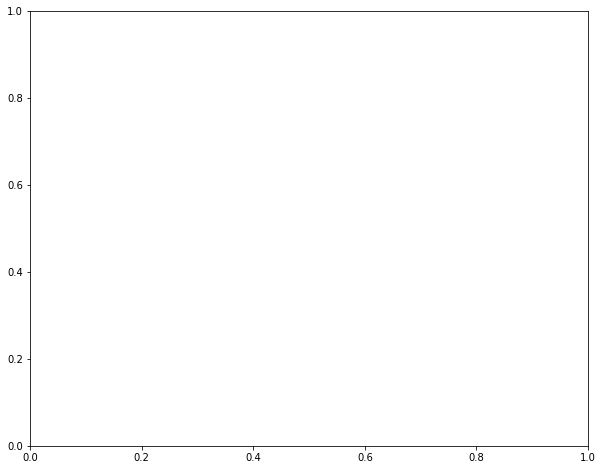

In [19]:
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(10,8))
plt.scatter(Distribution_df_Ret36_pso['Volatility']*100,Distribution_df_Ret36_pso['Expected_return']*100)
#plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Portfolio volatility Ret36 (%)')
plt.ylabel('Expeted portfolio return (%)')
#plt.xlim([0.17, 0.34])
plt.grid()

In [ ]:
#def Sharpe_ratio_ga(Rp,Rf,Sig):
#    Sharpe = []
#    for i in range(0,len(Rp)):
#        Sharpe.append((Rp[i] - Rf)/Sig[i])
#    return Sharpe

In [ ]:
#SR_Ret36_ga = Sharpe_ratio_ga(Distribution_df_Ret36_pso['Expected_return']*100,0.10,Distribution_df_Ret36_pso['Volatility']*100)
#Distribution_df_Ret36_pso['Sharpe ratio'] = SR_Ret36_ga

In [ ]:
Distribution_df_Ret36_pso

In [ ]:
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(10,8))
plt.scatter(Distribution_df_Ret36_pso['Volatility']*100,Distribution_df_Ret36_pso['Expected_return']*100,c=Distribution_df_Ret36_pso['Sharpe ratio'],\
            cmap='RdYlGn')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Portfolio volatility Ret36 (%)')
plt.ylabel('Expeted portfolio return (%)')
#plt.xlim([0.17, 0.34])
plt.grid()

In [ ]:
#np.dot(particle.position,np.transpose(self.returns))
#np.dot(np.dot(particle.position,self.vol),np.transpose(particle.position))
#V = np.dot(Distribution_df_Ret36_pso.loc[i].values,(np.dot(cov_mvo,Distribution_df_Ret36_pso.loc[i].values)))
#m = np.dot(mean_mvo,Distribution_df_Ret36_pso.loc[i])
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['Returns','Volatility','Sharpe_ratio'] + [ticker for ticker in tickers])
        
    return results_df

In [ ]:
cov_mvo
mean_returns_Ret36 = mean_mvo.values
#mean_returns_Ret36 = Ret36.mean().values
#cov_Ret36 = Ret36.cov()
num_portfolios = 3000
rf = 0.10
tickers = Ret36.columns 
results_frame_Ret36 = simulate_random_portfolios(num_portfolios, mean_returns_Ret36, cov_mvo, rf)


In [ ]:
print('Max sharpe ratio in the array (Ret36): {}'.format(results_frame_Ret36.Sharpe_ratio.max()))
print('Its location in the array is (Ret36): {}'.format(results_frame_Ret36.Volatility.argmax()))

In [ ]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port_Ret36 = results_frame_Ret36.iloc[results_frame_Ret36['Sharpe_ratio'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port_Ret36 = results_frame_Ret36.iloc[results_frame_Ret36['Volatility'].idxmin()]

In [ ]:
max_sharpe_port_Ret36 

In [ ]:
min_vol_port_Ret36

In [ ]:
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(10,8))
plt.scatter(results_frame_Ret36.Volatility*100,results_frame_Ret36.Returns*100,c=results_frame_Ret36.Sharpe_ratio,cmap='RdYlGn')
#plt.plot(results_frame.Returns,results_frame.Volatility)
plt.colorbar(label='Sharpe_ratio')
plt.xlabel('Volatility(%)')
plt.ylabel('Returns Ret36(%)')
plt.plot(Distribution_df_Ret36_pso['Volatility']*100,Distribution_df_Ret36_pso['Expected_return']*100,'ro-')
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port_Ret36[1]*100,max_sharpe_port_Ret36[0]*100,marker=(5,1,0),color='b',s=500)

#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port_Ret36[1]*100,min_vol_port_Ret36[0]*100,marker=(5,1,0),color='m',s=500)
plt.grid()
plt.show()


In [ ]:
def get_ret_vol_sr_Ret36(weights_Ret36):
    weights_Ret36 = np.array(weights_Ret36)
    ret_Ret36 = np.sum(mean_returns_Ret36*weights_Ret36)
    vol_Ret36 = np.sqrt(np.dot(weights_Ret36.T, np.dot(cov_mvo, weights_Ret36)))
    sr_Ret36 = ret_Ret36/vol_Ret36
    return np.array([ret_Ret36, vol_Ret36, sr_Ret36])

def neg_sharpe_Ret36(weights_Ret36):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return (-1)*get_ret_vol_sr_Ret36(weights_Ret36)[2]

def check_sum_Ret36(weights_Ret36):
    #return 0 if sum of the weights is 1
    return np.sum(weights_Ret36)-1


In [ ]:

cons_Ret36 = ({'type':'eq','fun':check_sum_Ret36})
bound = (0.0,1.0)
bounds = tuple(bound for asset in range(len(tickers)))
init_guess = len(tickers)*[1./len(tickers),]


In [ ]:
from scipy.optimize import minimize
opt_results_Ret36 = minimize(neg_sharpe_Ret36,init_guess,method='SLSQP',bounds=bounds,constraints=cons_Ret36)

In [ ]:
def minimize_volatility_Ret36(weights_Ret36):
    return get_ret_vol_sr_Ret36(weights_Ret36)[1]

In [ ]:
Rmin = 0.22# Enter the minimum return for an admissible portfolio (in decimals)
Rmax = 0.50#np.mean(Ret36.median().values) # Pull the slider to change the value of Rmax
R = np.arange(Rmin, Rmax, 0.5/100)
R

In [ ]:
frontier_x = []
for possible_return in R:
    cons_Ret36 = ({'type':'eq', 'fun':check_sum_Ret36},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr_Ret36(w)[0] - possible_return})
    
    result = minimize(minimize_volatility_Ret36,init_guess,method='SLSQP', bounds=bounds, constraints=cons_Ret36)
    frontier_x.append(result['fun'])



In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(results_frame_Ret36.Volatility*100,results_frame_Ret36.Returns*100,c=results_frame_Ret36.Sharpe_ratio,cmap='RdYlGn')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_port_Ret36[1]*100,max_sharpe_port_Ret36[0]*100,marker=(5,1,0),color='b',s=100,label='Maximum Sharpe ratio')
plt.scatter(min_vol_port_Ret36[1]*100,min_vol_port_Ret36[0]*100,marker=(5,1,0),color='m',s=100,label='Minimum volatility')
plt.xlabel('Volatility Ret36(%)')
plt.ylabel('Return(%)')
plt.plot([i*100 for i in frontier_x],[i*100 for i in R], 'r-.', linewidth=3, label='Efficient frontier')
plt.grid()
plt.legend(labelspacing=0.8)
plt.show()